# Скрипт для проведения кластеризации
Данный скрипт позволяет выполнить иерархическую кластеризацию и методом k-средних. Для выполнения кластеризации замените только название файла и количество кластеров, которые планируете найти.

In [1]:
# загрузим библиотеки
# данные библиотеки являются стандартными для пакета Anaconda
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.cluster import KMeans
#данная строчка нужна для корректного отображения графиков
%matplotlib inline 

In [2]:
# Загрузим данные из xls документа
# При необходимости надо изменить название файла и листа, на котором находятся данные
# Проще всего файл положить в папку, где находиться и сам скрипт. В это случае укажите только название
# sheet_name - название листа, с котрого надо загрузить данные
data = pd.read_excel('ClustATI0011.xlsx', sheet_name='Лист1')
# команда data.head() выводит первые пять строчек загруженных в переменную дата данных
data.head()

,Имя,Чек,Статус,Заказы,Расстояние
0,Клиент 1,128.000000,0,1,10
1,Клиент 2,579.333333,0,3,4
2,Клиент 3,376.666667,0,6,21
3,Клиент 4,296.296000,0,1,10
4,Клиент 5,111.250000,1,16,17


# Изучение структуры данных
Следующие действия не относятся напрямую к поиску кластеров, но лучшее понимание данных позволяет более качественно выполнить кластеризацию.

In [3]:
# посомтрим основные статистические параметры данных
data.describe()

,Чек,Статус,Заказы,Расстояние
count,2956.000000,2956.000000,2956.000000,2956.000000
mean,377.531648,0.320365,7.662382,15.158322
std,695.546854,0.466696,20.246477,20.980580
min,0.200000,0.000000,1.000000,0.000000
25%,120.000000,0.000000,1.000000,9.000000
50%,207.046667,0.000000,2.000000,10.000000
75%,380.000000,1.000000,5.000000,11.000000
max,14450.000000,1.000000,324.000000,238.000000


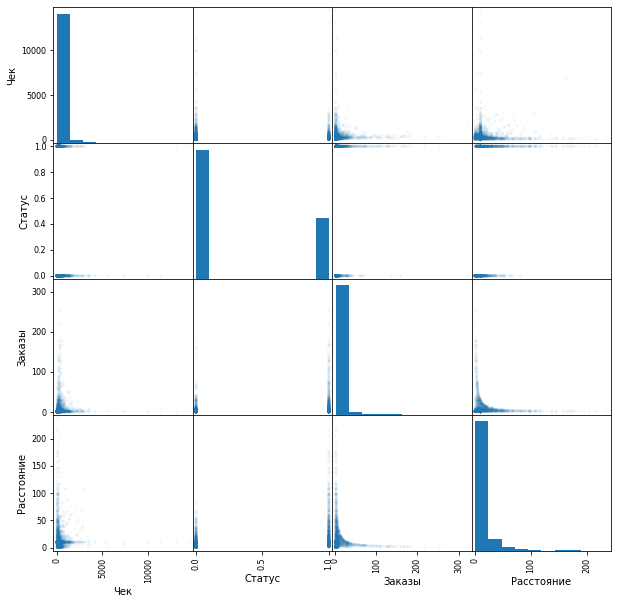

In [4]:
# построим диаграммы рассеивания и гистограммы для столбцов
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.05, figsize=(10, 10));

In [ ]:
# посмотрим наличие корреляций между значениями
data.corr()

In [ ]:
# Изменяя названия столбцов можно построить диаграммы рассеиванию двух параметров
# Замените названия стобцов col1 и col2
col1 = 'Чек'
col2 = 'Заказы'

plt.figure(figsize=(10, 6))

plt.scatter(data[col1],
            data[col2],
            alpha=0.75,
            color='red')
plt.xlabel(col1)
plt.ylabel(col2)

# Готовим данные к кластеризации
Следующие операции необходимы для подготовки данных

In [ ]:
# Выделим данные, начиная с первой колонки
# Это то, что подлежит анализу
# данную операцию надо проделывать на рядах с названием строк
# следующая команда удаляет столбец client, он не содержаит данных для кластеризации
data_for_clust=data.drop(data.columns[0], axis=1).values
#проверим результат, выведем первую строку
data_for_clust[0]

In [ ]:
# загружаем библиотеку препроцесинга данных
# эта библиотека автоматически приведен данные к нормальным значениям
from sklearn import preprocessing
dataNorm = preprocessing.scale(data_for_clust)

In [ ]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
# Вычисляется евклидово расстояние (по умолчанию)
data_dist = pdist(dataNorm, 'euclidean')
# Главная функция иерархической кластеризии
# Объедение элементов в кластера и сохранение в 
# специальной переменной (используется ниже для визуализации 
# и выделения количества кластеров
data_linkage = linkage(data_dist, method='average')

In [ ]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("clusters:", k)

In [ ]:
#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
#
# указываем количество кластеров!
#
nCluster=6

#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nCluster, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

Фактически, мы сейчас выполнили иерархическую кластеризацию для построения дендограмы

# Метод иерархической кластеризации
Ее можно выполнять указывая или максимальное расстояние между класстерами (ячейка ниже) или указывая количество кластеров (через одну)

In [ ]:
#импортируем дополнительную библиотеку 
from scipy.cluster.hierarchy import fcluster
max_d = 50 #максимальное расстояние, можно изменять
# находим количество кластеров, между которыми растояние более max_d
clusters = fcluster(data_linkage, max_d, criterion='distance')
clusters

In [ ]:
k=6 #заданное количество кластеров. Можно менять
clusters=fcluster(data_linkage, k, criterion='maxclust')
clusters

In [ ]:
# рисуем график. Выбираем лучшее с точки зрения разбиения.
plt.figure(figsize=(10, 8))
# изменяя номеря сечений, можем выводить распределения в любых осях
plt.scatter(data_for_clust[:,0], data_for_clust[:,3], c=clusters, cmap='flag') 
plt.show()

Результат кластеризации - это одномерный массив с номер класстера к которому относится строка оригинальных данных. 
для удобства обработки мы совместим оригинальные данные и номера кластеров.

In [ ]:
# к оригинальным данным добавляем 
dataI=data
dataI['cluster_no']=clusters
# Имя и название файла ниже можно изменять. Если файл не существует, то будем создан
# sheet_name - имя листа на который будет записан результат
writer = pd.ExcelWriter('result003.xlsx')
dataI.to_excel(writer,'IER')
writer.save()

# Кластеризация методом k-means

In [ ]:
# строим кластеризаци методом KMeans
#
# n_clusters - укажите количество кластеров, которые вам необходимы
#
km = KMeans(n_clusters=6).fit(dataNorm)

In [ ]:
# выведем полученное распределение по кластерам
# так же номер кластера, к котрому относится строка, так как нумерация начинается с нуля, выводим добавляя 1
km.labels_ +1

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data_for_clust[:,0], data_for_clust[:,2], c=km.labels_, cmap='flag')
plt.show()

In [ ]:
# к оригинальным данным добавляем номера кластеров
dataK=data
dataK['group_no']=clusters
# Имя и название файла ниже можно изменять. Если файл не существует, то будем создан
writer = pd.ExcelWriter('result005.xlsx')
dataK.to_excel(writer,'KMeans')
writer.save()